In [1]:
from io import BytesIO
import json
import glob
import os
import requests
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.patches as patches

Больше подробностей в документации: 
* https://mcs.mail.ru/docs/ru/ml/vision/manage-vision/vision-api-obj
* https://mcs.mail.ru/docs/ru/additionals/api/vision-api

In [2]:
 # определение эндпойнтов
HOST = "https://smarty.mail.ru"

URL_OBJ_DETECT = HOST + "/api/v1/objects/detect"
URL_FR_RECOGNIZE = HOST + "/api/v1/persons/recognize"
URL_OCR_DETECT = HOST + "/api/v1/scene_text/recognize"

In [3]:
# Прописываем token в файл
# with open('token', 'w') as tf:
#     token = input()
#     tf.write(token)

In [4]:
# подготовка параметров для авторизации запросов
oauth_provider = "mcs"
oauth_token_path = "./token"
with open(oauth_token_path, "r") as f:
    oauth_token = f.read()

# для пробрасывания авторизации в URL
authorization_params = {
    "oauth_provider": oauth_provider, 
    "oauth_token": oauth_token
}

In [5]:
def plot_image(image, figsize=(15, 15)):
    """Функция для отрисовки изображений внутри ноутбучка"""
    plt.figure(figsize=figsize)
    plt.imshow(image, interpolation="lanczos")
    plt.axis('off')

# Распознавание людей на мероприятии и группировка фотографий в альбом

Сценарий:
1. Распознаём людей по лицу
2. Детектируем текст на изображении
3. Объединяем фотографии по участнику
4. Фильтруем фотографии по тегу

## Распознаём людей по лицу

In [6]:
def vision_request(URL: str, img: bytes, extended_meta: dict):
    """Функция обертка для упрощенной отправки запроса к эндпойнту objects/detect"""
    # создать словарь с файлами для параметра files в post запросе
    files = {}
    name = "file_0"
    files[name] = img
    
    # создать meta: Параметры запроса передаются в формате JSON в теле запроса с name="meta"
    meta = {
        "images": [{"name":name}]
    }
    meta.update(extended_meta)
    data = {'meta': json.dumps(meta)}
    
    response = requests.post(URL, params=authorization_params, data=data, files=files)
    return response

In [7]:
 def parse_person_recognize_result(response: requests.models.Response) -> list:
    """
    Парсинг респонса с найденными лицами. Возвращает list из person id
    
    RETURN
    ['person1', 'person2', ... ,'person14']
    """
    
    body = response.json()["body"]
    persons = []
    try:
        recognized_persons = body['objects'][0]["persons"]
        for person_info in recognized_persons:
            persons.append(person_info['tag'])
        
    except KeyError as e:
        pass
    return persons

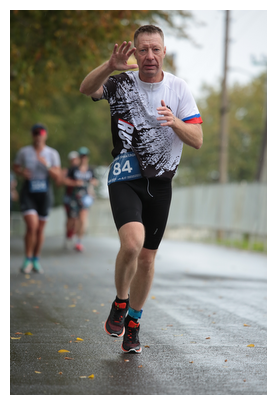

In [8]:
 # укажите путь до фотографии 
image_path = "./photo_for_demo/photo10.jpg"
with open(image_path, "rb") as image:
    image_raw = image.read()
image = plt.imread(image_path)
plot_image(image, figsize=(5, 5))

In [9]:
response = vision_request(URL_FR_RECOGNIZE, img=image_raw, extended_meta={"space": "2", "create_new": True})
response.json()

{'status': 200,
 'body': {'objects': [{'status': 0,
    'name': 'file_0',
    'persons': [{'tag': 'person1',
      'coord': [969, 193, 1196, 511],
      'confidence': 0.99999,
      'awesomeness': 0.5121,
      'similarity': 0.9991,
      'sex': 'male',
      'emotion': 'Sadness',
      'age': 65,
      'valence': -0.4325,
      'arousal': 0.026,
      'frontality': 0.994,
      'visibility': 0.9972}]}]},
 'htmlencoded': False,
 'last_modified': 0}

In [10]:
recognized_persons = {}
for image_path in tqdm(glob.glob('./photo_for_demo/*.jpg')):
    img_name = os.path.basename(image_path).split('.')[0]
    with open(image_path, "rb") as image:
        image_raw = image.read()
    response = vision_request(URL_FR_RECOGNIZE, img=image_raw, extended_meta={"space": "2", "create_new": True})
    recognized_persons[img_name] = parse_person_recognize_result(response)

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
recognized_persons

{'photo3': ['person2'],
 'photo4': [],
 'photo1': ['person3', 'person4'],
 'photo11': ['person7'],
 'photo9': ['person1'],
 'photo8': ['person1'],
 'photo6': ['person5'],
 'photo5': ['person3', 'person4'],
 'photo7': ['person1'],
 'photo10': ['person1'],
 'photo2': ['person6']}

## Детектируем текст на изображении

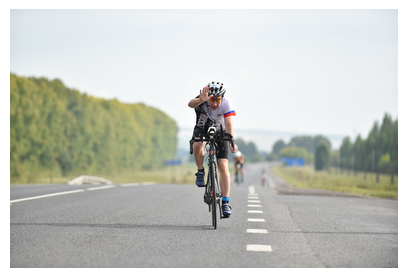

In [12]:
 # укажите путь до фотографии 
image_path = "./photo_for_demo/photo7.jpg"
with open(image_path, "rb") as image:
    image_raw = image.read()
image = plt.imread(image_path)
plot_image(image, figsize=(5, 5))

In [13]:
response = vision_request(URL_OCR_DETECT, img=image_raw, extended_meta={})
response.json()

{'status': 200,
 'body': {'objects': [{'status': 0,
    'name': 'file_0',
    'words': [{'coord': [[1564, 582], [1599, 582], [1599, 601], [1564, 601]],
      'prob': 0.9953492595588174,
      'text': '84'},
     {'coord': [[1824, 1414], [2007, 1414], [2007, 1878], [1824, 1878]],
      'prob': 0.04368025970001544,
      'text': 'WILLIDA'}]}]},
 'htmlencoded': False,
 'last_modified': 0}

In [14]:
 def parse_ocr_recognize_result(response: requests.models.Response) -> list:
    """
    Парсинг респонса с найденными текстами. Возвращает list из текстов
    
    RETURN
    ['text1', 'text2', ... ,'text14']
    """
    
    body = response.json()["body"]
    texts = []
    try:
        recognized_texts = body['objects'][0]['words']
        for text_info in recognized_texts:
            texts.append(text_info['text'])
        
    except KeyError as e:
        pass
    return texts

In [15]:
recognized_texts = {}
for image_path in tqdm(glob.glob('./photo_for_demo/*.jpg')):
    img_name = os.path.basename(image_path).split('.')[0]
    with open(image_path, "rb") as image:
        image_raw = image.read()
    response = vision_request(URL_OCR_DETECT, img=image_raw, extended_meta={})
    recognized_texts[img_name] = parse_ocr_recognize_result(response)

  0%|          | 0/11 [00:00<?, ?it/s]

# Объединяем фотографии по участнику

In [16]:
person_images = set()
for img_name, persons in recognized_persons.items():
    if 'person1' in persons:
        person_images.add(img_name)
for img_name, texts in recognized_texts.items():
    if '84' in texts:
        person_images.add(img_name)

In [17]:
person_images

{'photo10', 'photo11', 'photo7', 'photo8', 'photo9'}

## Фильтруем фотографии по тегу

In [18]:
def parse_label_detect_result(response: requests.models.Response) -> list:
    """
    Парсинг респонса с найденными текстами. Возвращает list из текстов
    
    RETURN
    ['text1', 'text2', ... ,'text14']
    """
    
    body = response.json()["body"]
    labels = []
    try:
        recognized_labels = body['object_labels'][0]['labels']
        for label_info in recognized_labels:
            labels.append(label_info["rus"])
        
    except KeyError as e:
        pass
    return labels

In [19]:
detected_tags = {}
for image_path in tqdm(glob.glob('./photo_for_demo/*.jpg')):
    img_name = os.path.basename(image_path).split('.')[0]
    with open(image_path, "rb") as image:
        image_raw = image.read()
    response = vision_request(URL_OBJ_DETECT, img=image_raw, extended_meta={"mode": ["object"]})
    detected_tags[img_name] = parse_label_detect_result(response)

  0%|          | 0/11 [00:00<?, ?it/s]

In [20]:
selected_tags = {'Велосипед', 'Велосипедное колесо', 'Езда на велосипеде', 'Велоспорт', 'Велосипедный шлем'}

album_photos = []
for img_name, tags in detected_tags.items():
    if len(set(tags) & selected_tags) > 0 and img_name in person_images:
        album_photos.append(img_name)

### Смотрим на фотографии из альбома

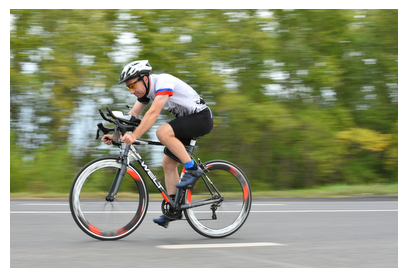

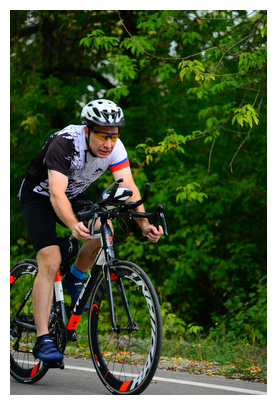

In [ ]:
for album_photo in album_photos:
    image_path = f"./photo_for_demo/{album_photo}.jpg"
    image = plt.imread(image_path)
    plot_image(image, figsize=(5, 5))